In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'CNN2DoubleInput'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import modulephaselib

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

## Data transformation

In [9]:
transformed_signals = modulephaselib.all_I_Q_to_module_phase(signals)

### Training and Test data partitioning

In [10]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

iq_train, transformed_train, iq_test, transformed_test, Y_train, Y_test = traintestsplitlib.split_double_x_y_train_test(signals, transformed_signals, labels, mods, train_index, test_index)

## Build the Neural Network

In [11]:
iq_shp = list(iq_train.shape[1:])
transformed_shp = list(transformed_train.shape[1:])

print(iq_train.shape)
print(iq_shp)
print(transformed_train.shape)
print(transformed_shp)

classes = mods

(165000, 2, 128)
[2, 128]
(165000, 2, 128)
[2, 128]


In [12]:
model = neural_networks.rml201610a_VTCNN2_v2_double_input(iq_shp, transformed_shp)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2, 128)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2, 128)]     0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 2, 128, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 2, 128, 1)    0           input_2[0][0]                    
______________________________________________________________________________________________

### Train the model

In [13]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train_double_input(filepath, model, iq_train, transformed_train, Y_train, BATCH_SIZE, NB_EPOCH)

Epoch 1/100
146/146 [==============================] - 27s 58ms/step - loss: 2.3980 - val_loss: 2.3980
Epoch 2/100
146/146 [==============================] - 7s 51ms/step - loss: 2.3979 - val_loss: 2.3979
Epoch 3/100
146/146 [==============================] - 7s 51ms/step - loss: 2.3979 - val_loss: 2.3979
Epoch 4/100
146/146 [==============================] - 8s 51ms/step - loss: 2.3979 - val_loss: 2.3959
Epoch 5/100
146/146 [==============================] - 7s 51ms/step - loss: 2.3774 - val_loss: 2.2374
Epoch 6/100
146/146 [==============================] - 7s 51ms/step - loss: 2.2227 - val_loss: 2.1098
Epoch 7/100
146/146 [==============================] - 7s 51ms/step - loss: 2.1174 - val_loss: 2.0214
Epoch 8/100
146/146 [==============================] - 7s 51ms/step - loss: 2.0442 - val_loss: 1.9606
Epoch 9/100
146/146 [==============================] - 8s 51ms/step - loss: 2.0053 - val_loss: 1.9438
Epoch 10/100
146/146 [==============================] - 7s 51ms/step - loss: 1.98

# Evaluate and Plot Model Performance

In [14]:
# Show simple version of performance
score = model.evaluate((iq_test, transformed_test), Y_test, batch_size=BATCH_SIZE)
print(score)

54/54 [==============================] - 1s 15ms/step - loss: 1.7132
1.7131606340408325


## Loss

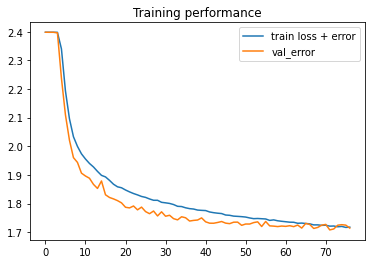

In [15]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

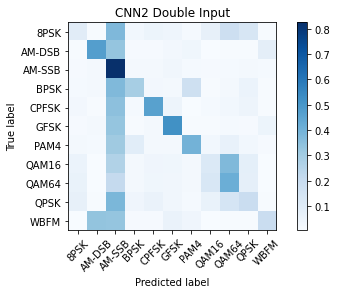

In [16]:
evaluationlib.plot_double_input_confusion_matrix(model, NEURAL_NETWORK_NAME, iq_test, transformed_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08135215453194651
Overall Accuracy:  0.09685767097966728
Overall Accuracy:  0.09225874867444327
Overall Accuracy:  0.08959943780744906
Overall Accuracy:  0.09356936416184972
Overall Accuracy:  0.11672037235947011
Overall Accuracy:  0.14188462916517378
Overall Accuracy:  0.20784883720930233
Overall Accuracy:  0.2797302094426695
Overall Accuracy:  0.3835370237239396
Overall Accuracy:  0.45352214960058096
Overall Accuracy:  0.5218175261449693
Overall Accuracy:  0.5753320683111954
Overall Accuracy:  0.5671641791044776
Overall Accuracy:  0.5695244956772334
Overall Accuracy:  0.6062705067444404
Overall Accuracy:  0.5934838948537579
Overall Accuracy:  0.5998495675065815
Overall Accuracy:  0.5965364775239499
Overall Accuracy:  0.5982078853046595


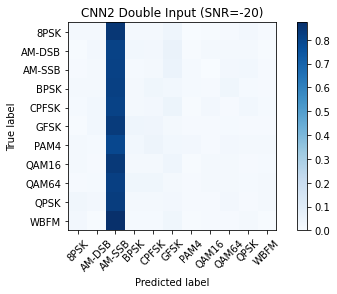

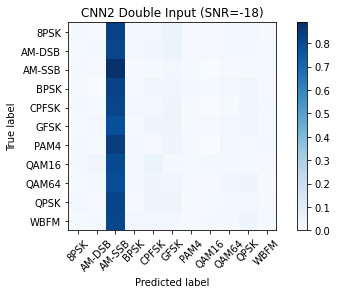

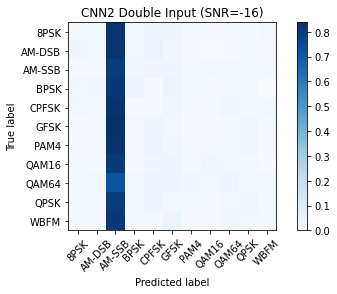

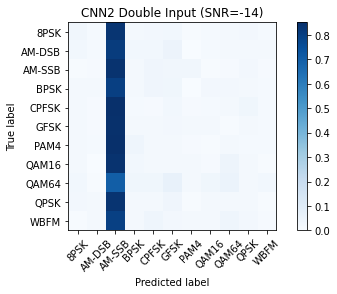

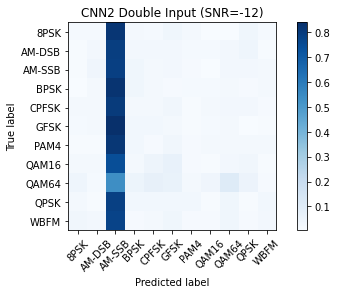

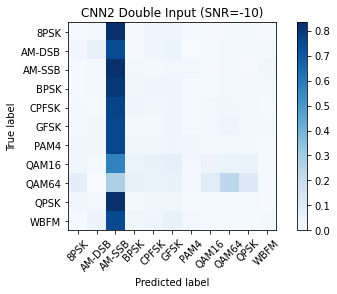

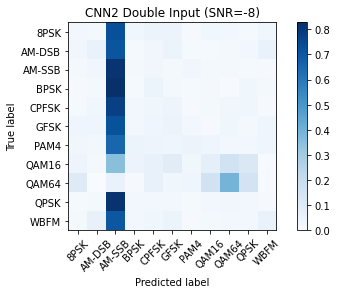

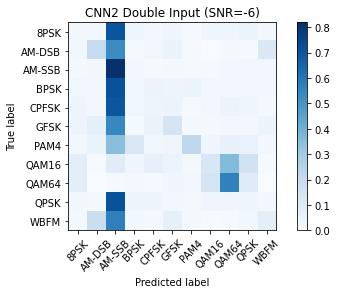

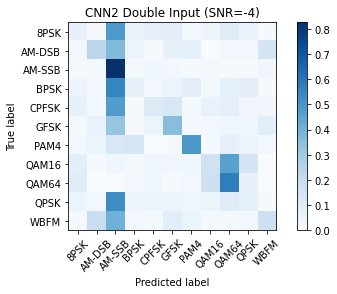

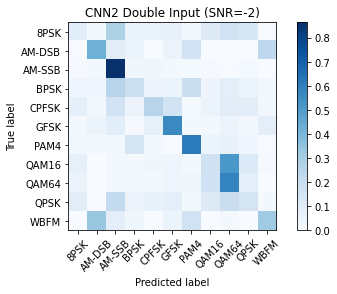

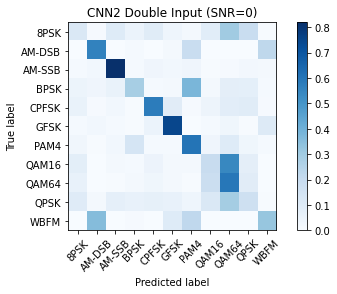

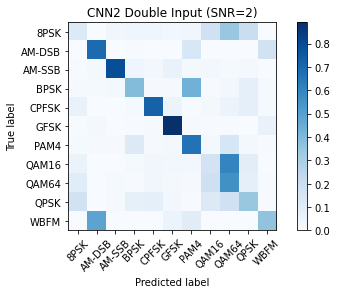

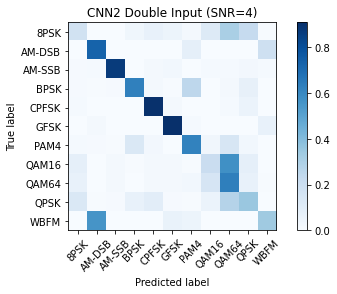

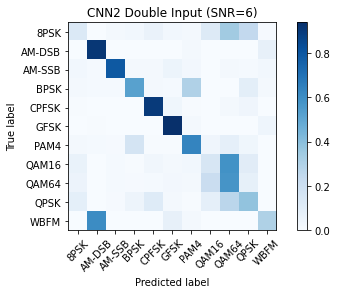

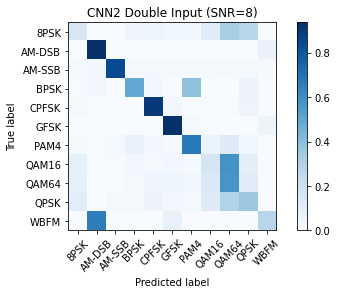

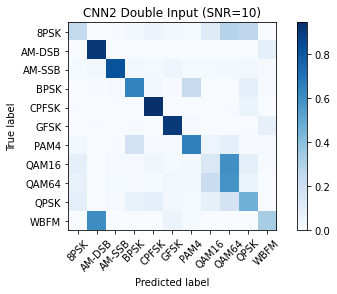

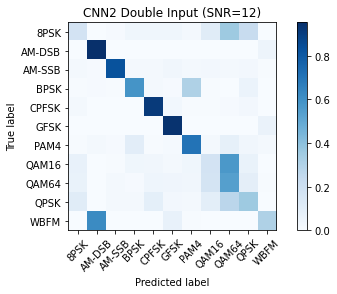

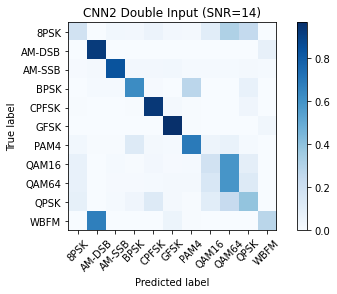

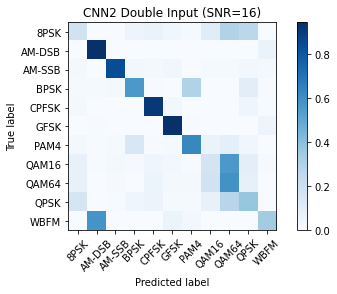

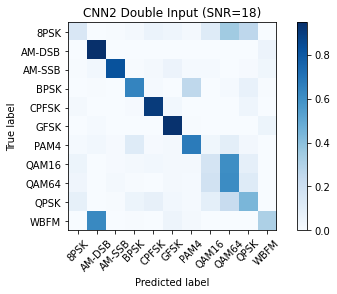

In [17]:
acc = evaluationlib.plot_double_input_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, iq_test, transformed_test, Y_test, test_index, classes)

## Accuracy performance

In [18]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,9,8,9,11,14,20,27,38,45,52,57,56,56,60,59,59,59,59


In [19]:
# Save results to a pickle file for plotting later
# fd = open(OUTPUT_FILENAME,'wb')
# pickle.dump( ("CNN2", 0.5, acc) , fd )

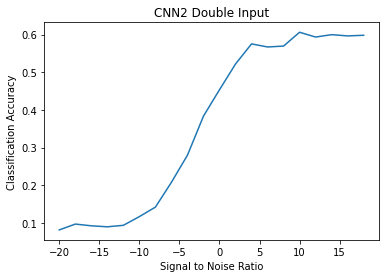

In [20]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)